In [15]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#dataset = "groupon"
#dataset = "horse"
dataset = "nhanes"

data = pd.read_parquet(f"/Users/andres.hoyosidrobo/Downloads/pairing/experiment/{dataset}/results.parquet")
print(data.head())
print(data.columns)

                                 matching      diff       smd   n0   n1  \
0                            bart_nearest -0.002174  0.405245  251  251   
1                            bart_optimal -0.002770  0.023812  251  251   
2  bipartify_identity_logistic-regression -0.001456  0.031782  201  201   
3                bipartify_identity_psmpy -0.002094  0.055753  201  201   
4        bipartify_identity_random-forest -0.002214  0.044423  201  201   

     target       split_id                                         method  
0 -0.079681  matchitrealxp                            matchitbart_nearest  
1 -0.019920  matchitrealxp                            matchitbart_optimal  
2 -0.014925  matchitrealxp  matchitbipartify_identity_logistic-regression  
3 -0.009950  matchitrealxp                matchitbipartify_identity_psmpy  
4 -0.024876  matchitrealxp        matchitbipartify_identity_random-forest  
Index(['matching', 'diff', 'smd', 'n0', 'n1', 'target', 'split_id', 'method'], dtype='object'

In [16]:
ate = data['diff'].abs().values
smd = data["smd"].values

points = np.hstack([ate[:, np.newaxis], smd[:, np.newaxis]])
df_points = pd.DataFrame(points, columns=['ate', 'smd'])

# Min norm selection

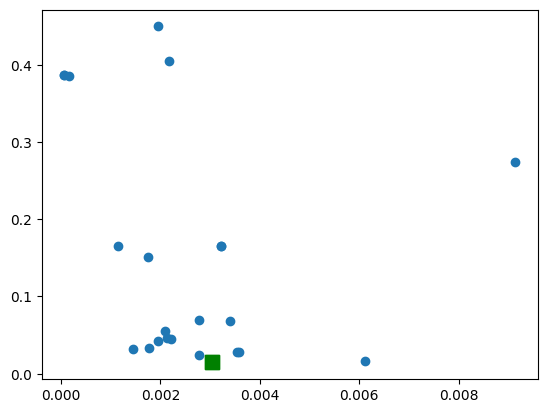

In [17]:
norms = np.linalg.norm(points, axis=1)

selected = norms == norms.min()

plt.scatter(points[:, 0], points[:, 1])
plt.scatter(points[selected, 0], points[selected, 1], color="g", marker="s", s=100)

# Max curvature selection

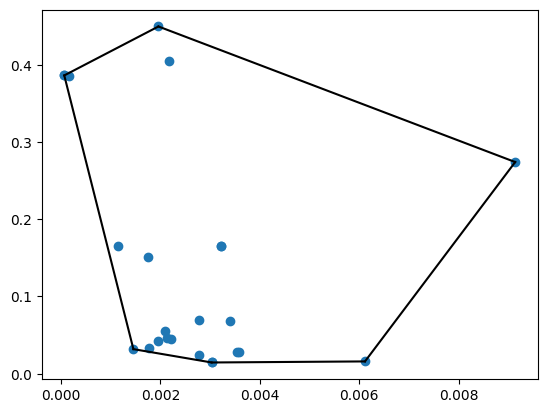

In [18]:
from scipy.spatial import ConvexHull


hull = ConvexHull(points)

plt.plot(points[:,0], points[:,1], 'o')

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [19]:
vertex = np.vstack([points[s] for s in hull.simplices])
df_vertex = pd.DataFrame(vertex, columns=['ate', 'smd'])
vv = df_vertex.sort_values('ate').drop_duplicates().values

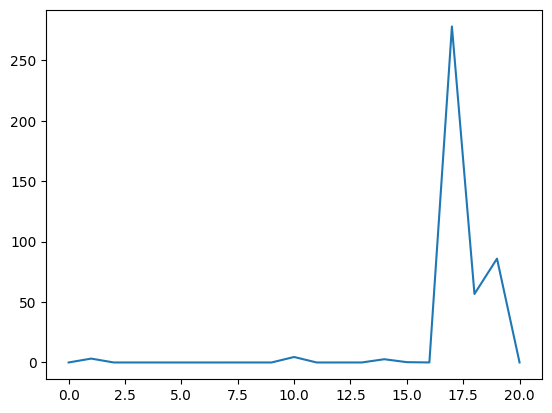

In [20]:
from scipy.interpolate import CubicSpline
from typing import Callable


def get_curvature(
    cs: Callable, 
    x: np.ndarray,
) -> np.ndarray:
    num = np.abs(cs(x, 2)) 
    den = np.float_power(1 + cs(x, 1) ** 2, 1.5)
    return np.nan_to_num(num / den)


pp = df_points.sort_values("ate").drop_duplicates().values

cs = CubicSpline(pp[:, 0], pp[:, 1])
kappa = get_curvature(cs, pp[:, 0])

kappa[0] = 0
kappa[-1] = 0

plt.plot(kappa)

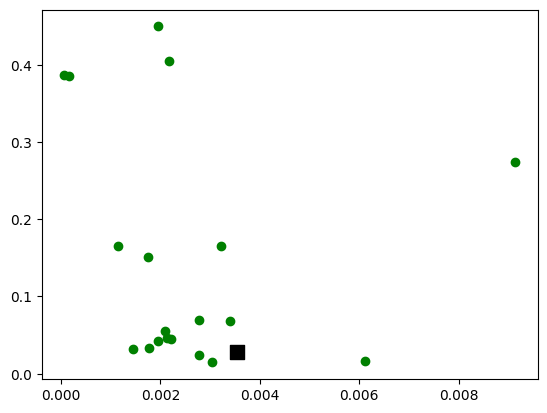

In [21]:
kappa_id = kappa == kappa.max()

plt.scatter(pp[:, 0], cs(pp[:, 0]), color='g')

plt.scatter(pp[kappa_id, 0], pp[kappa_id, 1], color='k', s=100, marker='s')

# Pareto

In [26]:
# From: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python

def is_pareto_efficient_simple(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient]<c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

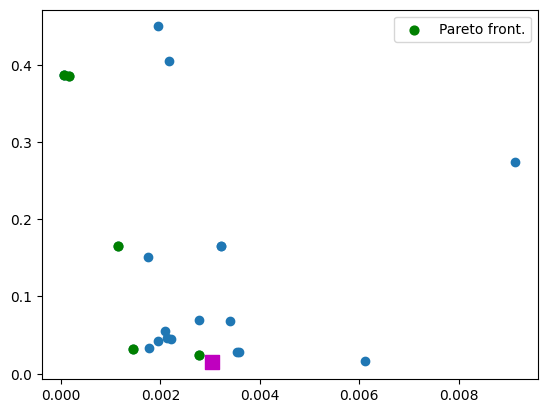

In [29]:
selected = is_pareto_efficient_simple(points)


selected_points = points[selected]
norms = np.linalg.norm(selected_points, axis=1) 

min_norm_selection = norms == norms.min()

plt.scatter(points[:, 0], points[:, 1])
plt.scatter(points[selected, 0], points[selected, 1], color="g", marker="o", s=40, label="Pareto front.")
plt.scatter(selected_points[min_norm_selection, 0], selected_points[min_norm_selection, 1], color="m", marker="s", s=100)

plt.legend()